In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import HTML
from scipy.io import loadmat
from matplotlib.animation import FuncAnimation
import seaborn
from mpl_toolkits import mplot3d
from itertools import compress
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing
from joblib import Parallel, delayed
from utils import *
import random

In [2]:
NumThread=(multiprocessing.cpu_count()-1)*2 # sets number of workers based on cpus on current machine
#to check if the models are run on the instance, not locally:
multiprocessing.cpu_count()


128

In [3]:
def load(mat_file = 'saccade_data_2.mat', channels = [130,131]):
    # Load the .mat file
    mat = loadmat(mat_file)
    # Extract the saccade_data cell array. Note that this will be a structured numpy array.
    saccade_data = mat[list(mat.keys())[-1]][0]
    
    #selectively return the channels of interest ommitting all other
    extracted_saccades=[]
    for saccade in saccade_data:
        channel_sacs = []
        for channel in channels:
            channel_sacs.append( np.ndarray.tolist(saccade[channel]) )
        extracted_saccades.append(np.array(channel_sacs))
    return extracted_saccades
def normalize(saccades):
    for i in range(len(saccades)):
        for j in range(len(saccades[i])):
            saccades[i][j] = (saccades[i][j]-np.mean(saccades[i][j]))/np.std(saccades[i][j])
    return saccades
def car_to_polar(saccades):
    for i in range(len(saccades)):
        x=saccades[i][0]
        y=saccades[i][1]
        rho=np.sqrt(x**2+y**2)
        phi=np.arctan2(y,x)
        saccades[i]=np.array([rho,phi])
    return saccades

In [4]:
sac_pos = load('/mnt/home/mplomecka/saccades/data/newdata/filteredData_antiright_old.mat')

scales = np.array([0.008])
Ts = np.array([3])
trajectories = []

random.shuffle(sac_pos)
selected_trajectories = random.sample(sac_pos, 250)

for sac in selected_trajectories:
    trajectories.append(sac[0])

Ts_p = np.flip(np.tile(Ts, len(scales)))
scales_p = np.repeat(scales, len(Ts), axis=0)


def get_last_five_points_mean(trajectories):
    means = []

    for index, trajectory in enumerate(trajectories):
        last_five_points = trajectory[-5:]
        mean_of_last_five = np.mean(last_five_points)
        means.append((index, mean_of_last_five))

    # Sort the list by the mean value
    means.sort(key=lambda x: x[1])

    return means


with tqdm_joblib(tqdm(desc="FTLEs", total=len(Ts_p))) as progress_bar:
    results = Parallel(n_jobs=NumThread)(delayed(compute_FTLEs_parallel)(trajectories, scale=scale, T=T, delay_dimension=5, num_singular_vectors=3)
                                        for T, scale in zip(Ts_p, scales_p))
all_ftles = {}
for index, (T, scale) in enumerate(zip(Ts_p, scales_p)):
    all_ftles[(T, scale)] = results[index]

# means of the last five points of each trajectory
means = get_last_five_points_mean(trajectories)

# divide the sorted list into three bins
bins = np.array_split(np.array(means), 3)

# Now bins[0], bins[1], and bins[2] contain the lower, middle, and upper third of the trials, respectively
lower_bin_indices = [i[0] for i in bins[0]]
middle_bin_indices = [i[0] for i in bins[1]]
upper_bin_indices = [i[0] for i in bins[2]]

# lower bin
lower_bin_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in lower_bin_indices]
    if len(selected_indices) > 0:
        lower_bin_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }

# middle bin
middle_bin_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in middle_bin_indices]
    if len(selected_indices) > 0:
        middle_bin_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }

# upper bin
upper_bin_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in upper_bin_indices]
    if len(selected_indices) > 0:
        upper_bin_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }


FTLEs: 100%|██████████| 1/1 [1:11:08<00:00, 4268.49s/it]


plotted together:

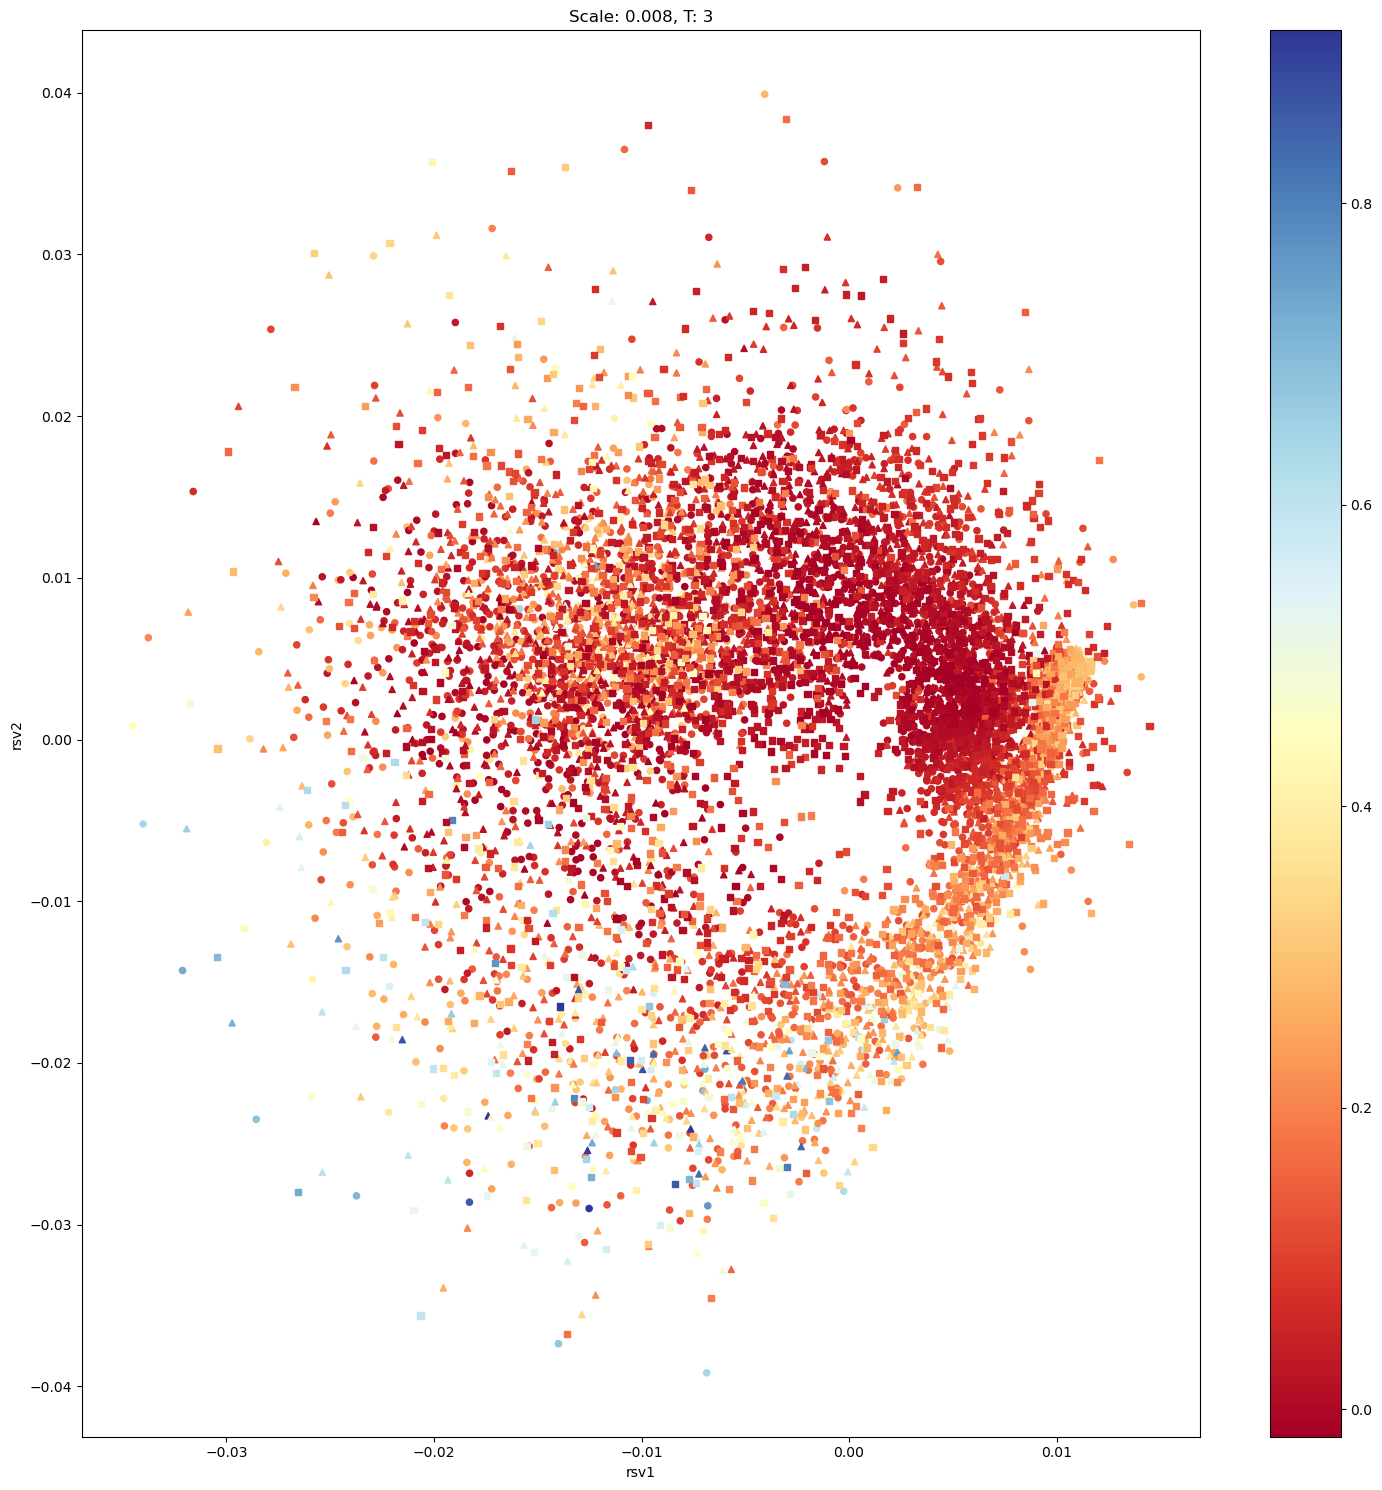

In [5]:
fig = plt.figure(figsize=(15, 15))
cm = plt.cm.get_cmap('RdYlBu')

plot_index = 1

for T in Ts:
    for scale in scales:
        vc_lower = lower_bin_results[(T, scale)]['vc']
        les_lower = np.max(lower_bin_results[(T, scale)]['les_vc'], axis=1)
        vc_middle = middle_bin_results[(T, scale)]['vc']
        les_middle = np.max(middle_bin_results[(T, scale)]['les_vc'], axis=1)
        vc_upper = upper_bin_results[(T, scale)]['vc']
        les_upper = np.max(upper_bin_results[(T, scale)]['les_vc'], axis=1)

        ax = fig.add_subplot(len(Ts), len(scales), plot_index)
        p_lower = ax.scatter(vc_lower[1], vc_lower[2], s=20, c=les_lower, cmap=cm)
        p_middle = ax.scatter(vc_middle[1], vc_middle[2], s=20, c=les_middle, cmap=cm, marker='^')
        p_upper = ax.scatter(vc_upper[1], vc_upper[2], s=20, c=les_upper, cmap=cm, marker='s')

        ax.set_xlabel('rsv1')
        ax.set_ylabel('rsv2')
        ax.set_title(f'Scale: {scale}, T: {T}')
        fig.colorbar(p_lower, ax=ax)

        plot_index += 1

plt.tight_layout()
plt.show()


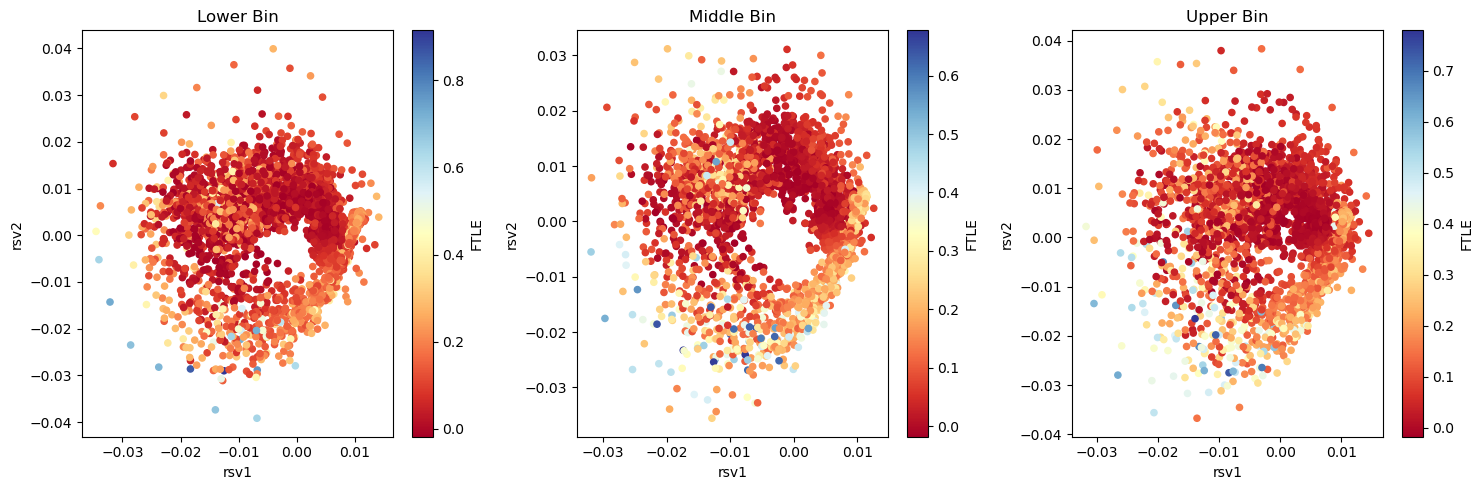

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cm = plt.cm.get_cmap('RdYlBu')

#markers = ['o', '^', 's']  # Circles, triangles, squares
titles = ['Lower Bin', 'Middle Bin', 'Upper Bin']
datasets = [lower_bin_results, middle_bin_results, upper_bin_results]

for k, ax in enumerate(axes):
    for i, T in enumerate(Ts):
        for j, scale in enumerate(scales):
            dataset = datasets[k]
            vc = dataset[(T, scale)]['vc']
            les = np.max(dataset[(T, scale)]['les_vc'], axis=1)

            p = ax.scatter(vc[1], vc[2], s=20, c=les, cmap=cm) #marker=markers[k])

        ax.set_xlabel('rsv1')
        ax.set_ylabel('rsv2')
    
        ax.set_title(titles[k])
        fig.colorbar(p, ax=ax, label='FTLE')

plt.tight_layout()
plt.show()


/tmp/ipykernel_2041715/1979529533.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


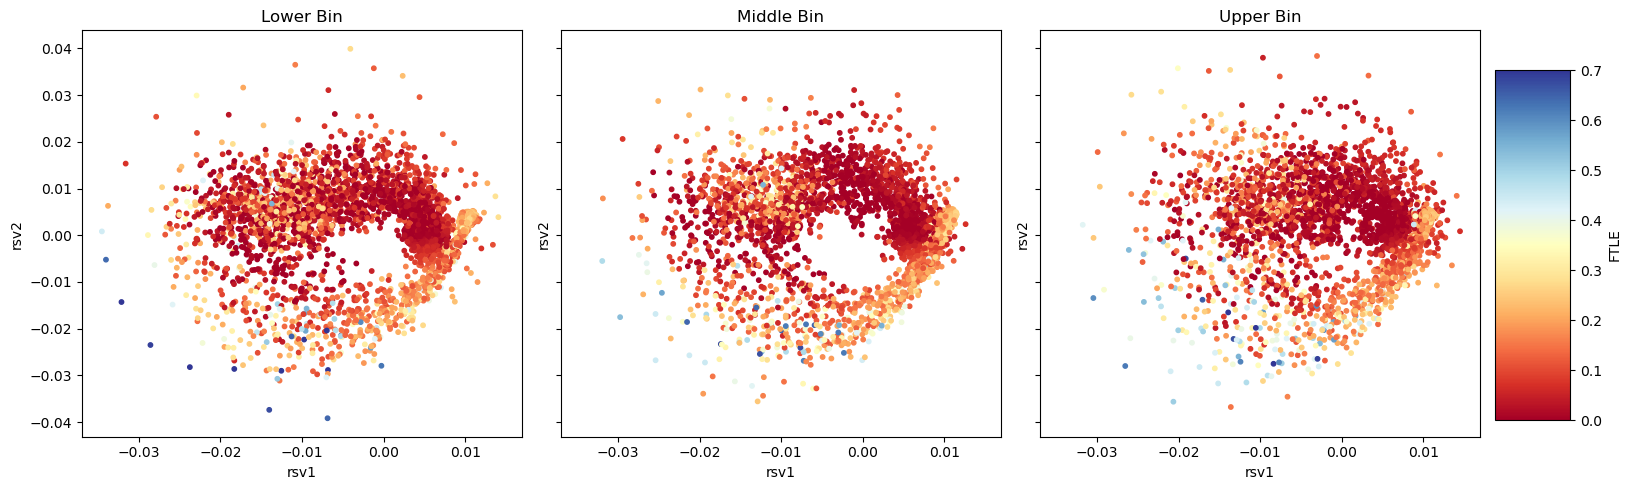

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

cm = plt.cm.get_cmap('RdYlBu')

titles = ['Lower Bin', 'Middle Bin', 'Upper Bin']
datasets = [lower_bin_results, middle_bin_results, upper_bin_results]

for k, ax in enumerate(axes):
    for i, T in enumerate(Ts):
        for j, scale in enumerate(scales):
            dataset = datasets[k]
            vc = dataset[(T, scale)]['vc']
            les = np.max(dataset[(T, scale)]['les_vc'], axis=1)
            p = ax.scatter(vc[1], vc[2], s=10, c=les, cmap=cm, vmin=0, vmax=0.7) 

        ax.set_xlabel('rsv1')
        ax.set_ylabel('rsv2')
        ax.set_title(titles[k])

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])  
fig.colorbar(p, cax=cbar_ax, label='FTLE')

plt.tight_layout()
plt.show()


another way of splitting:

In [43]:
sac_pos = load('/mnt/home/mplomecka/saccades/data/newdata/filteredData_antiright_old.mat')

scales = np.array([0.008])
Ts = np.array([3])
trajectories = []

random.shuffle(sac_pos)
selected_trajectories = random.sample(sac_pos, 250)

for sac in selected_trajectories:
    trajectories.append(sac[0])

Ts_p = np.flip(np.tile(Ts, len(scales)))
scales_p = np.repeat(scales, len(Ts), axis=0)

In [44]:

with tqdm_joblib(tqdm(desc="FTLEs", total=len(Ts_p))) as progress_bar:
    results = Parallel(n_jobs=NumThread)(delayed(compute_FTLEs_parallel)(trajectories, scale=scale, T=T, delay_dimension=5, num_singular_vectors=3)
                                        for T, scale in zip(Ts_p, scales_p))
all_ftles = {}
for index, (T, scale) in enumerate(zip(Ts_p, scales_p)):
    all_ftles[(T, scale)] = results[index]

FTLEs: 100%|██████████| 1/1 [1:09:29<00:00, 4169.05s/it]


In [56]:
def bin_by_threshold(trajectories, lower_threshold=130, upper_threshold=190):
    bin1_indices = []
    bin2_indices = []
    bin3_indices = []
    
    for index, trajectory in enumerate(trajectories):
        last_five_points = trajectory[-5:]
        mean_of_last_five = np.mean(last_five_points)

        if mean_of_last_five < lower_threshold:
            bin1_indices.append(index)
        elif lower_threshold <= mean_of_last_five < upper_threshold:
            bin2_indices.append(index)
        else:
            bin3_indices.append(index)
            
    return bin1_indices, bin2_indices, bin3_indices

bin1_indices, bin2_indices, bin3_indices = bin_by_threshold(trajectories)


# bin1
bin1_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin1_indices]
    if len(selected_indices) > 0:
        bin1_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }

# bin2
bin2_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin2_indices]
    if len(selected_indices) > 0:
        bin2_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }

# bin3
bin3_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin3_indices]
    if len(selected_indices) > 0:
        bin3_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }


In [57]:
bin1_results

{(3,
  0.008): {'lyv_vc': array([[0.54640059, 0.53811201, 0.47297468, ..., 0.84624386, 0.83242596,
          0.89245936],
         [0.20471774, 0.20992864, 0.22064508, ..., 0.2381924 , 0.30625804,
          0.27683752],
         [0.81211886, 0.81631209, 0.853001  , ..., 0.47658757, 0.46181493,
          0.35619837]]), 'les_vc': array([[ 0.22726183,  0.04433197, -0.01957889],
         [ 0.22579283,  0.04213189, -0.01976924],
         [ 0.22631307,  0.02741994, -0.02081855],
         ...,
         [ 0.03543895, -0.01767713, -0.16226302],
         [ 0.04003333, -0.01823833, -0.21663577],
         [ 0.01740205, -0.01899995, -0.19478612]]), 'vc': array([[-0.01344189, -0.01343665, -0.01343185, ..., -0.00416501,
          -0.00418168, -0.00418911],
         [ 0.01038579,  0.01038172,  0.01039232, ...,  0.00436373,
           0.00378106,  0.00327265],
         [ 0.00405831,  0.0041315 ,  0.00440242, ..., -0.00187924,
          -0.00243944, -0.00086844]]), 'ly_ids': array([ 16,  16,  16,  16,  

/tmp/ipykernel_2041715/4164317767.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


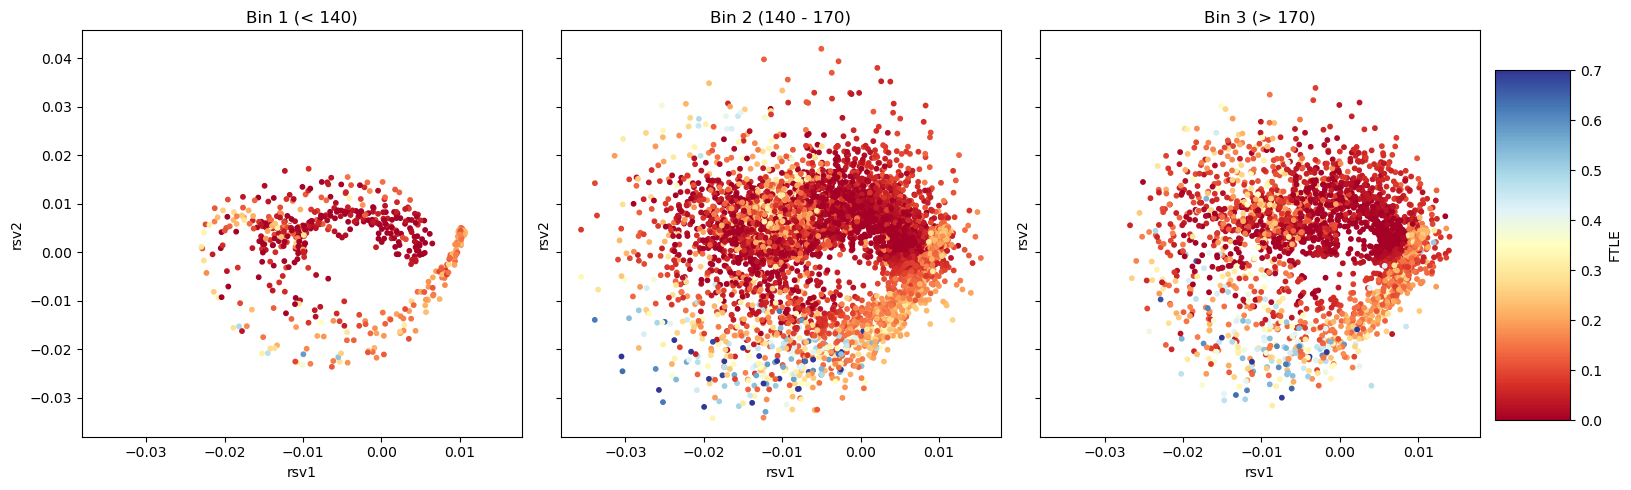

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

cm = plt.cm.get_cmap('RdYlBu')

titles = ['Bin 1 (< 140)', 'Bin 2 (140 - 170)', 'Bin 3 (> 170)']  
datasets = [bin1_results, bin2_results, bin3_results]  

for k, ax in enumerate(axes):
    for i, T in enumerate(Ts):
        for j, scale in enumerate(scales):
            dataset = datasets[k]
            vc = dataset[(T, scale)]['vc']
            les = np.max(dataset[(T, scale)]['les_vc'], axis=1)
            p = ax.scatter(vc[1], vc[2], s=10, c=les, cmap=cm, vmin=0, vmax=0.7) 

        ax.set_xlabel('rsv1')
        ax.set_ylabel('rsv2')
        ax.set_title(titles[k])

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])  
fig.colorbar(p, cax=cbar_ax, label='FTLE')

plt.tight_layout()
plt.show()


percentiles

In [59]:
def bin_by_percentiles(trajectories):
    bin1_indices = []
    bin2_indices = []
    bin3_indices = []
    
    # Calculate the means of the last five points
    means = [np.mean(trajectory[-5:]) for trajectory in trajectories]

    # Calculate 10th and 90th percentiles
    lower_threshold, upper_threshold = np.percentile(means, [10, 90])
    
    for index, mean in enumerate(means):
        if mean < lower_threshold:
            bin1_indices.append(index)
        elif lower_threshold <= mean < upper_threshold:
            bin2_indices.append(index)
        else:
            bin3_indices.append(index)
            
    return bin1_indices, bin2_indices, bin3_indices

# Get the indices of the bins
bin1_indices, bin2_indices, bin3_indices = bin_by_percentiles(trajectories)


In [60]:


# bin1
bin1_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin1_indices]
    if len(selected_indices) > 0:
        bin1_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }

# bin2
bin2_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin2_indices]
    if len(selected_indices) > 0:
        bin2_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }

# bin3
bin3_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin3_indices]
    if len(selected_indices) > 0:
        bin3_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }


/tmp/ipykernel_2041715/2255355299.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


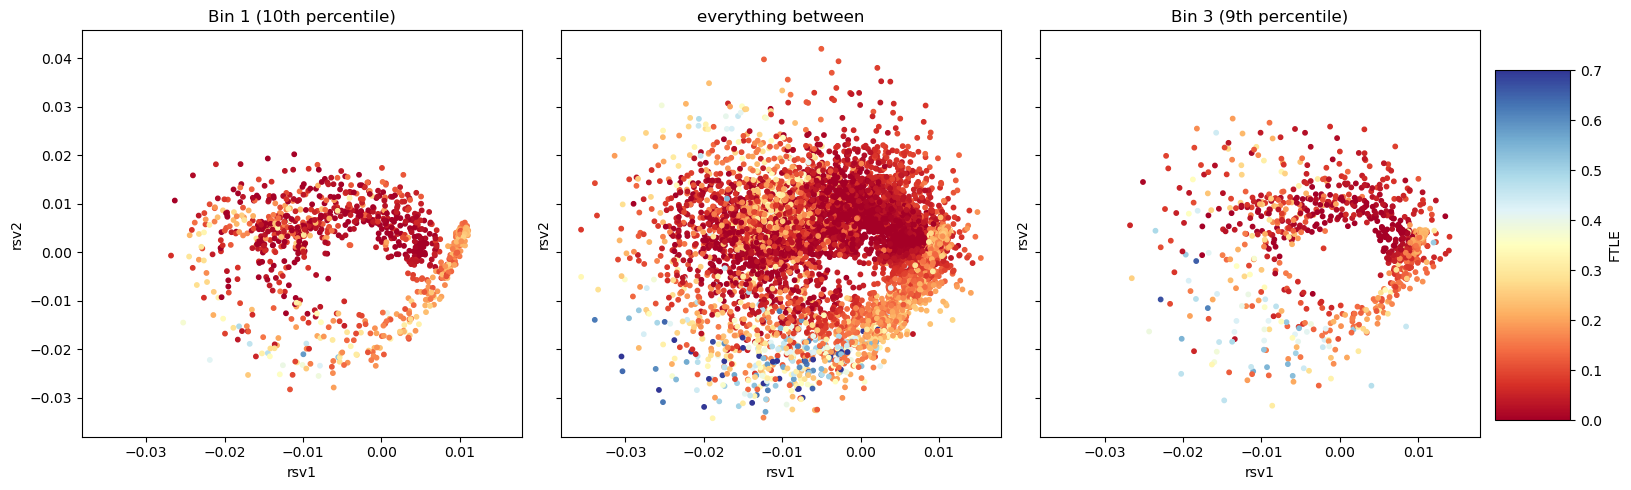

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

cm = plt.cm.get_cmap('RdYlBu')

titles = ['Bin 1 (10th percentile)', 'everything between', 'Bin 3 (9th percentile)']  
datasets = [bin1_results, bin2_results, bin3_results]  

for k, ax in enumerate(axes):
    for i, T in enumerate(Ts):
        for j, scale in enumerate(scales):
            dataset = datasets[k]
            vc = dataset[(T, scale)]['vc']
            les = np.max(dataset[(T, scale)]['les_vc'], axis=1)
            p = ax.scatter(vc[1], vc[2], s=10, c=les, cmap=cm, vmin=0, vmax=0.7) 

        ax.set_xlabel('rsv1')
        ax.set_ylabel('rsv2')
        ax.set_title(titles[k])

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])  
fig.colorbar(p, cax=cbar_ax, label='FTLE')

plt.tight_layout()
plt.show()


----

In [62]:
#new strategy

def bin_by_distance_to_target(trajectories, target=150):
    bin1_indices = []
    bin2_indices = []
    bin3_indices = []

    # Calculate the means of the last five points
    means = [np.mean(trajectory[-5:]) for trajectory in trajectories]

    for index, mean in enumerate(means):
        distance_to_target = abs(target - mean)
        if distance_to_target < 10:
            bin1_indices.append(index)
        elif 10 <= distance_to_target < 30:
            bin2_indices.append(index)
        else:
            bin3_indices.append(index)

    return bin1_indices, bin2_indices, bin3_indices

bin1_indices, bin2_indices, bin3_indices = bin_by_distance_to_target(trajectories)


In [63]:


# bin1
bin1_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin1_indices]
    if len(selected_indices) > 0:
        bin1_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }

# bin2
bin2_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin2_indices]
    if len(selected_indices) > 0:
        bin2_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }

# bin3
bin3_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin3_indices]
    if len(selected_indices) > 0:
        bin3_results[key] = {
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        }


/tmp/ipykernel_2041715/3477702956.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


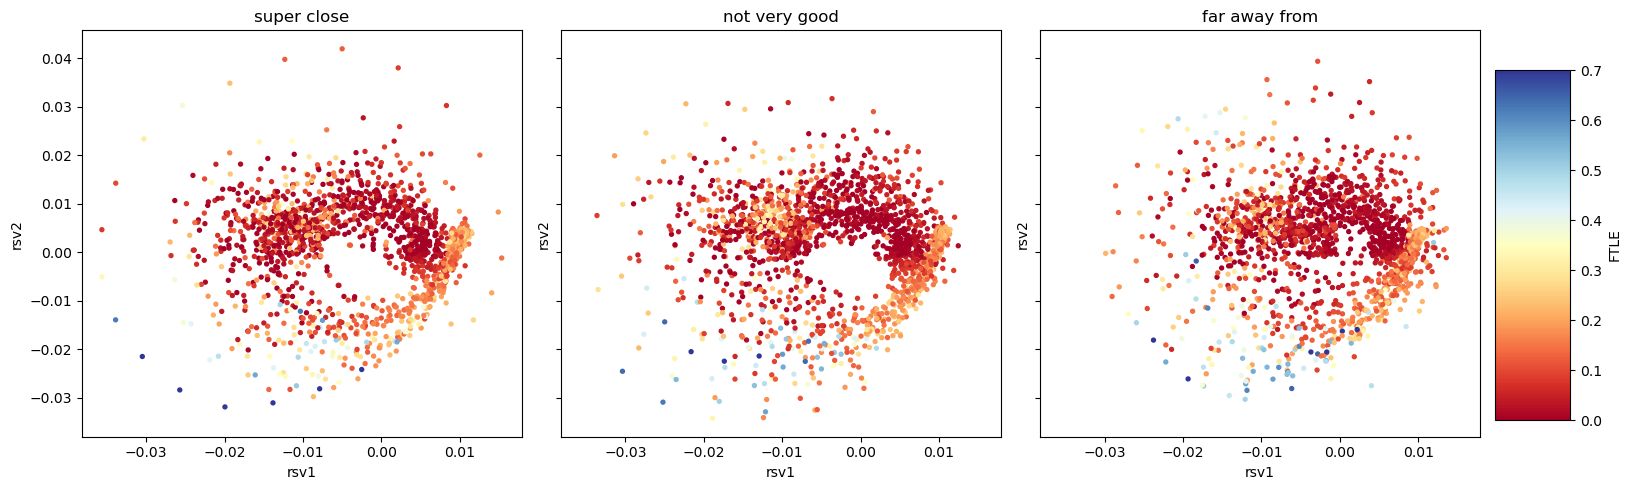

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

cm = plt.cm.get_cmap('RdYlBu')

titles = ['super close', 'not very good', 'far away from']  
datasets = [bin1_results, bin2_results, bin3_results]  

for k, ax in enumerate(axes):
    for i, T in enumerate(Ts):
        for j, scale in enumerate(scales):
            dataset = datasets[k]
            vc = dataset[(T, scale)]['vc']
            les = np.max(dataset[(T, scale)]['les_vc'], axis=1)
            p = ax.scatter(vc[1], vc[2], s=8, c=les, cmap=cm, vmin=0, vmax=0.7) 

        ax.set_xlabel('rsv1')
        ax.set_ylabel('rsv2')
        ax.set_title(titles[k])

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])  
fig.colorbar(p, cax=cbar_ax, label='FTLE')

plt.tight_layout()
plt.show()

-----

/tmp/ipykernel_2041715/781852707.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


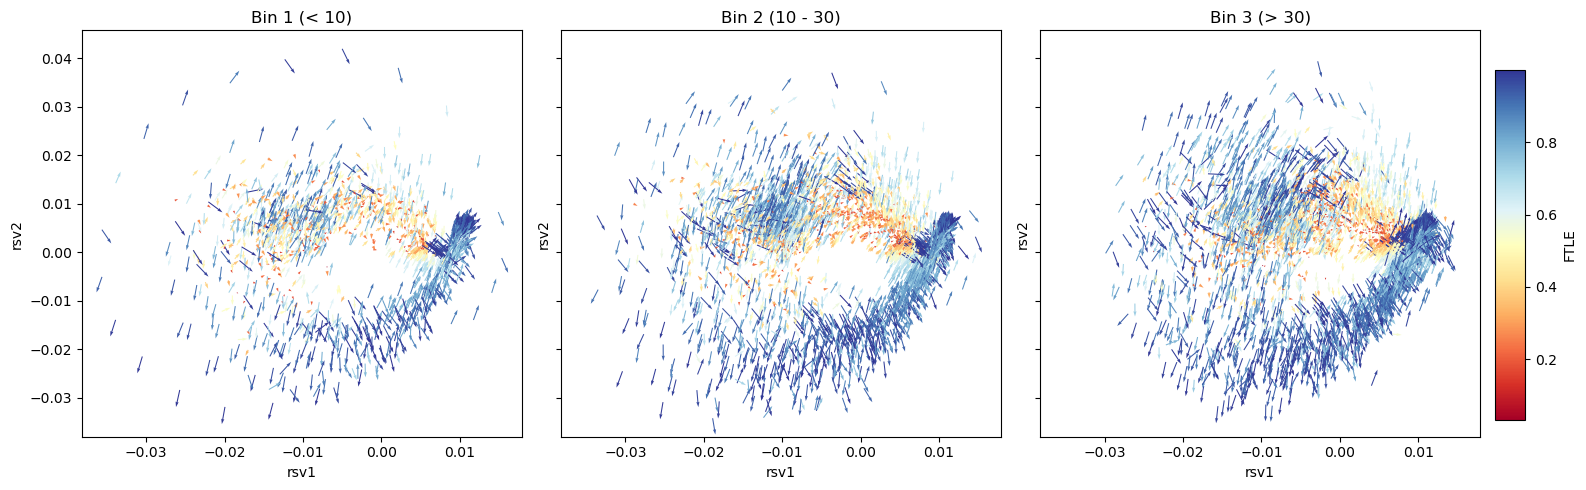

In [72]:


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

cm = plt.cm.get_cmap('RdYlBu')

titles = ['Bin 1 (< 10)', 'Bin 2 (10 - 30)', 'Bin 3 (> 30)']
datasets = [bin1_results, bin2_results, bin3_results]

for k, ax in enumerate(axes):
    for i, T in enumerate(Ts):
        for j, scale in enumerate(scales):
            dataset = datasets[k]
            vc = dataset[(T, scale)]['vc']
            les = np.max(dataset[(T, scale)]['les_vc'], axis=1)
            lyp_vc = dataset[(T, scale)]['lyv_vc'] 

            if lyp_vc.shape[1] == vc.shape[1]:  # only plot if shapes match
                # Calculate magnitude of vectors
                magnitude = np.sqrt(lyp_vc[1]**2 + lyp_vc[2]**2)
                # Normalize to [0,1]
                norm = plt.Normalize(magnitude.min(), magnitude.max())
                # Get corresponding colors from color map
                colors = cm(norm(magnitude))

                p = ax.quiver(vc[1], vc[2], lyp_vc[1], lyp_vc[2], color=colors, scale=25)

        ax.set_xlabel('rsv1')
        ax.set_ylabel('rsv2')
        ax.set_title(titles[k])

# Create a colorbar with the colormap
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  
fig.colorbar(sm, cax=cbar_ax, label='FTLE')

plt.tight_layout()
plt.show()


/tmp/ipykernel_2041715/2672956583.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


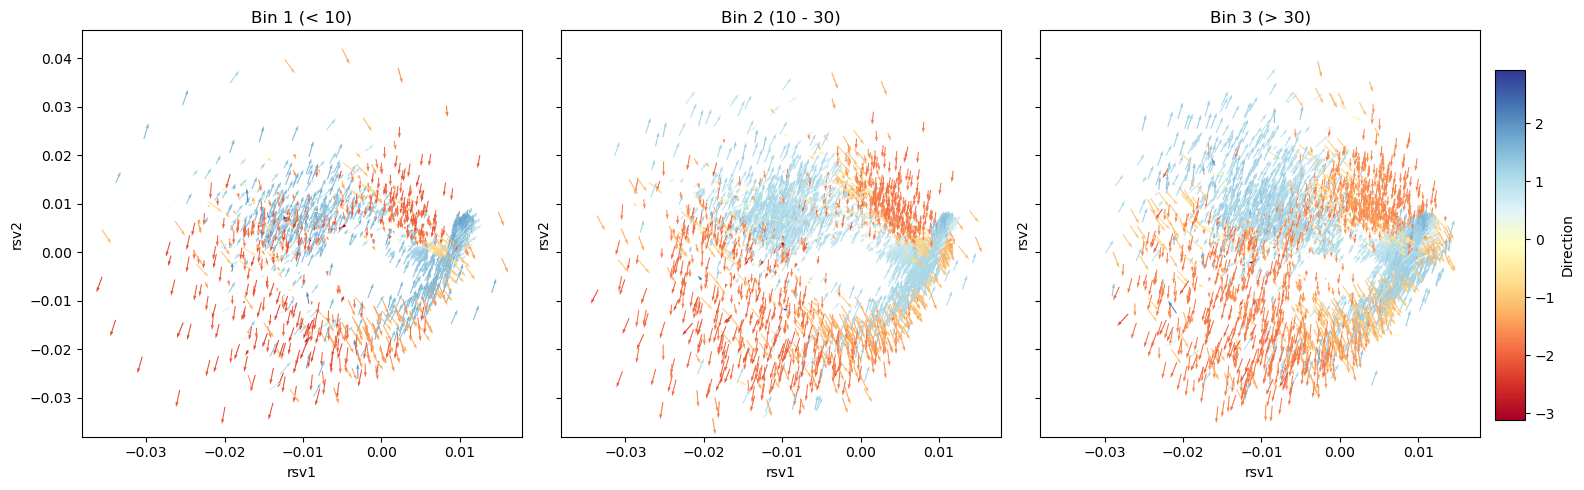

In [76]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

cm = plt.cm.get_cmap('RdYlBu')

titles = ['Bin 1 (< 10)', 'Bin 2 (10 - 30)', 'Bin 3 (> 30)']
datasets = [bin1_results, bin2_results, bin3_results]

for k, ax in enumerate(axes):
    for i, T in enumerate(Ts):
        for j, scale in enumerate(scales):
            dataset = datasets[k]
            vc = dataset[(T, scale)]['vc']
            les = np.max(dataset[(T, scale)]['les_vc'], axis=1)
            lyp_vc = dataset[(T, scale)]['lyv_vc'] 

            if lyp_vc.shape[1] == vc.shape[1]:  
                # Calculate direction of vectors (angle with x-axis)
                direction = np.arctan2(lyp_vc[2], lyp_vc[1])
                # Normalize to [0,1]
                norm = plt.Normalize(direction.min(), direction.max())
                # Get corresponding colors from color map
                colors = cm(norm(direction))

                p = ax.quiver(vc[1], vc[2], lyp_vc[1], lyp_vc[2], color=colors, scale=25)

        ax.set_xlabel('rsv1')
        ax.set_ylabel('rsv2')
        ax.set_title(titles[k])

# Create a colorbar with the colormap
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  
fig.colorbar(sm, cax=cbar_ax, label='Direction')

plt.tight_layout()
plt.show()


----

#### to make the balanced version -> choosing 50 trials per bin always!

In [96]:

def select_random_trajectories(results, num_trajectories=50):
    unique_ids = np.unique(results['ly_ids'])
    selected_ids = np.random.choice(unique_ids, size=min(len(unique_ids), num_trajectories), replace=False)

    selected_indices = [i for i, ly_id in enumerate(results['ly_ids']) if ly_id in selected_ids]

    return {
        'lyv_vc': results['lyv_vc'][:, selected_indices],
        'les_vc': results['les_vc'][selected_indices],
        'vc': results['vc'][:, selected_indices],
        'ly_ids': results['ly_ids'][selected_indices]
    }

# bin1
bin1_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin1_indices]
    if len(selected_indices) > 0:
        bin1_results[key] = select_random_trajectories({
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        })

# bin2
bin2_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin2_indices]
    if len(selected_indices) > 0:
        bin2_results[key] = select_random_trajectories({
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        })

# bin3
bin3_results = {}
for key, data in all_ftles.items():
    selected_indices = [i for i, ly_id in enumerate(data['ly_ids']) if ly_id in bin3_indices]
    if len(selected_indices) > 0:
        bin3_results[key] = select_random_trajectories({
            'lyv_vc': data['lyv_vc'][:, selected_indices],
            'les_vc': data['les_vc'][selected_indices],
            'vc': data['vc'][:, selected_indices],
            'ly_ids': data['ly_ids'][selected_indices]
        })


/tmp/ipykernel_2041715/1325520469.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


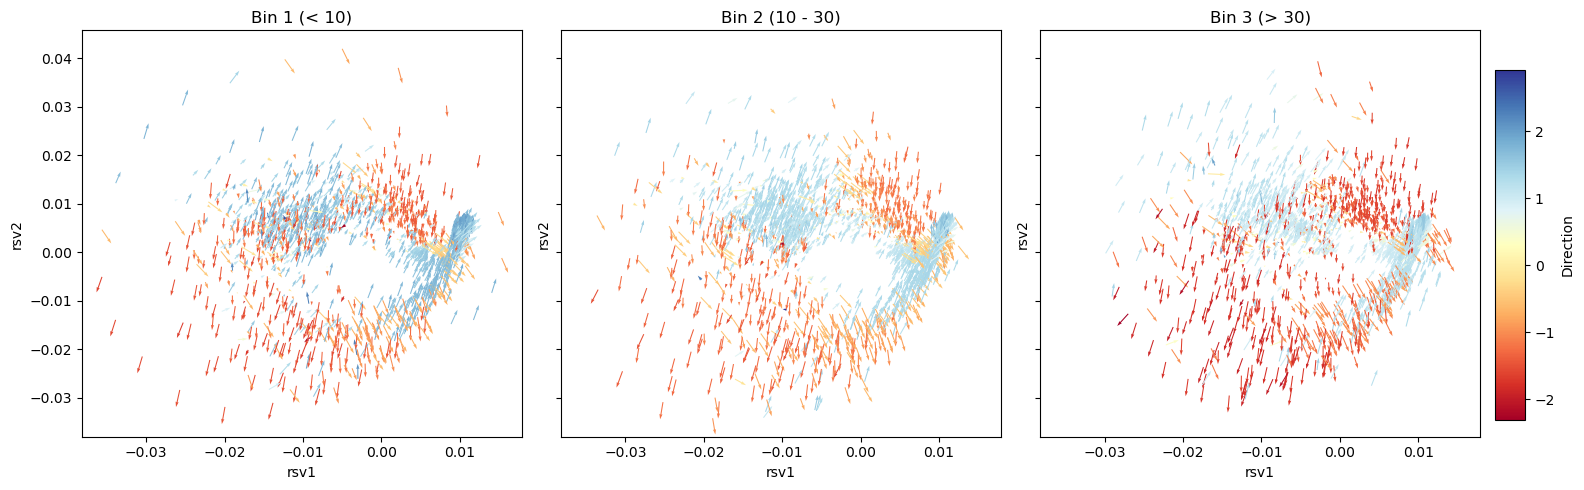

In [97]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

cm = plt.cm.get_cmap('RdYlBu')

titles = ['Bin 1 (< 10)', 'Bin 2 (10 - 30)', 'Bin 3 (> 30)']
datasets = [bin1_results, bin2_results, bin3_results]

for k, ax in enumerate(axes):
    for i, T in enumerate(Ts):
        for j, scale in enumerate(scales):
            dataset = datasets[k]
            vc = dataset[(T, scale)]['vc']
            les = np.max(dataset[(T, scale)]['les_vc'], axis=1)
            lyp_vc = dataset[(T, scale)]['lyv_vc'] 

            if lyp_vc.shape[1] == vc.shape[1]:  # only plot if shapes match
                # Calculate direction of vectors (angle with x-axis)
                direction = np.arctan2(lyp_vc[2], lyp_vc[1])
                # Normalize to [0,1]
                norm = plt.Normalize(direction.min(), direction.max())
                # Get corresponding colors from color map
                colors = cm(norm(direction))

                p = ax.quiver(vc[1], vc[2], lyp_vc[1], lyp_vc[2], color=colors, scale=25)

        ax.set_xlabel('rsv1')
        ax.set_ylabel('rsv2')
        ax.set_title(titles[k])

# Create a colorbar with the colormap
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  
fig.colorbar(sm, cax=cbar_ax, label='Direction')

plt.tight_layout()
plt.show()
